In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets

device = "cuda" if torch.cuda.is_available() else "cpu"

%load_ext autoreload
%autoreload 2

# DATA

In [2]:
TRAIN_FLAG = True
#DATA_SET = 'Shapes'
DATA_SET = 'MNIST'

In [3]:
import matplotlib.pyplot as plt

def plot_grid(data, grid_size=4):
    mat_data = data.data if hasattr(data, 'data') else data

    _, ax = plt.subplots(nrows=grid_size, ncols=grid_size, figsize=(8,8))

    for i in range(grid_size):
        for j in range(grid_size):
            ax[i][j].imshow(mat_data[i*grid_size+j].movedim(0, 2), cmap='gray')
            ax[i][j].axis('off')
    plt.tight_layout(pad=1)

In [4]:
import glob
import numpy as np
from PIL import Image
from utils.data import sample_indices


def load_shapes_dataset(dirpath='/mnt/Shared/shapes'):
    x = []
    y = []

    label_dict = {
        'circles' : 0,
        'squares' : 1,
        'triangles' : 2
    }

    files = glob.glob(dirpath + '/**/*.png', recursive=True)

    for f in files:
        img=Image.open(f)
        img=img.resize(size=(28,28))
        img=img.convert('L')
        x.append(np.array(img))
        label = f.split('/')[-2]
        #y.append(label_dict[label])
        y.append(label)
        del img

    return np.array(x), np.array(y)

torch.Size([500, 1, 28, 28]) torch.Size([50, 1, 28, 28])
tensor(0.) tensor(1.)


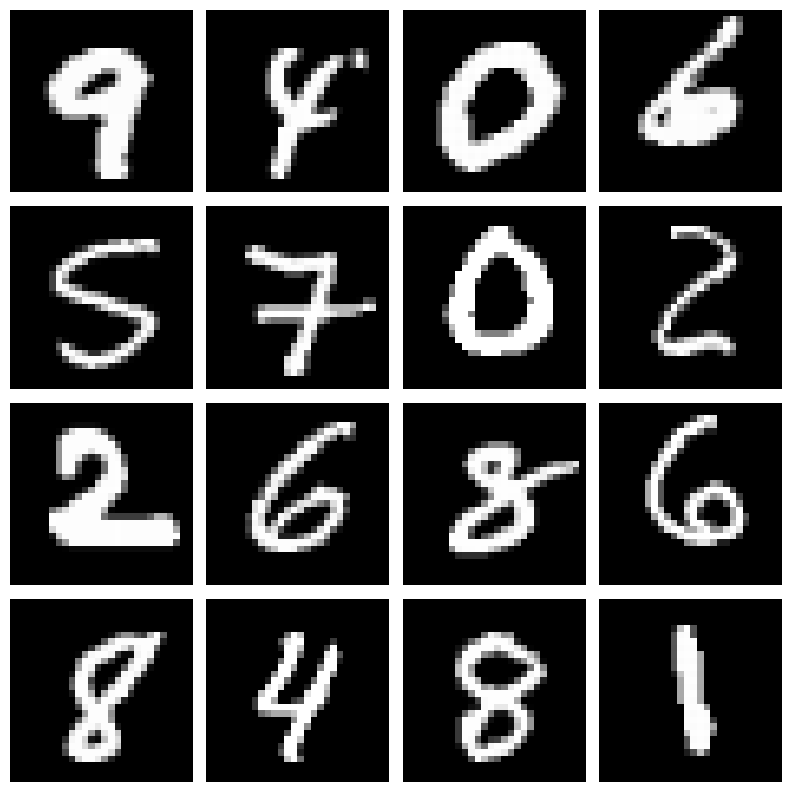

In [5]:
if DATA_SET == 'Shapes' :
    shapes, targets = load_shapes_dataset()
    shapes = 1 - shapes.reshape(-1, 1, 28, 28) / 255.
    print(shapes.shape)


    train_indeces = sample_indices(targets, k=90, seed=42)
    remaining_indeces = list(set(range(len(targets)))-set(train_indeces))
    test_indeces = sample_indices(targets[remaining_indeces], k=10, seed=42)
        
    train_dataset = torch.from_numpy(shapes[train_indeces].astype(np.float32))
    eval_dataset = torch.from_numpy(shapes[test_indeces].astype(np.float32))


elif DATA_SET == 'MNIST' :
    mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)

    train_indeces = sample_indices(mnist_trainset.targets, k=50, seed=42)
    remaining_indeces = list(set(range(len(mnist_trainset.targets)))-set(train_indeces))
    test_indeces = sample_indices(mnist_trainset.targets[remaining_indeces], k=5, seed=42)

    train_dataset = mnist_trainset.data[train_indeces].reshape(-1, 1, 28, 28) / 255.
    eval_dataset = mnist_trainset.data[test_indeces].reshape(-1, 1, 28, 28) / 255.

print(train_dataset.shape, eval_dataset.shape)
print(train_dataset.min(), train_dataset.max())

plot_grid(train_dataset)

In [6]:
# train_mean, train_std = train_dataset.mean(), train_dataset.std()
# train_dataset -= train_mean / train_std
# eval_dataset -= train_mean / train_std

# TRAIN

## Configure Training

In [7]:
from pythae.models import *
from pythae.models.nn.benchmarks.mnist import *
from pythae.models.nn.default_architectures import *
from pythae.models.base.base_utils import ModelOutput
from utils.models import Encoder_VAE_TinyMLP, Decoder_AE_TinyMLP

architecture_dict = {
    'tiny':
        {
        'encoder': Encoder_VAE_TinyMLP,
        'decoder': Decoder_AE_TinyMLP,
        },
    'mlp':
        {
        'encoder': Encoder_VAE_MLP,
        'decoder': Decoder_AE_MLP,
        },
    'convnet':
        {
        'encoder': Encoder_Conv_VAE_MNIST,
        'decoder': Decoder_Conv_AE_MNIST,
        },
    'resnet':
        {
        'encoder': Encoder_ResNet_VAE_MNIST,
        'decoder': Decoder_ResNet_AE_MNIST,
        },
    }


# model_config = RHVAEConfig(
#     input_dim=(1, 28, 28),
#     latent_dim=8,
#     reconstruction_loss="mse",
#     n_lf=3,
#     eps_lf=1e-3,
#     beta_zero=0.3,
#     temperature=0.8,
#     regularization=1e-2
# )

# model = RHVAE(
#     model_config=model_config,
#     encoder=architecture_dict['tiny']['encoder'](model_config),
#     decoder=architecture_dict['tiny']['decoder'](model_config),
# )

model_config = VAEConfig(
    input_dim=(1, 28, 28),
    latent_dim=8,
)

model = VAE(
    model_config=model_config,
    encoder=architecture_dict['convnet']['encoder'](model_config),
    decoder=architecture_dict['convnet']['decoder'](model_config),
)

In [8]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

%time count_parameters(model)

CPU times: user 112 µs, sys: 47 µs, total: 159 µs
Wall time: 163 µs


17084561

In [9]:
print(model)

VAE(
  (decoder): Decoder_Conv_AE_MNIST(
    (layers): ModuleList(
      (0): Linear(in_features=8, out_features=16384, bias=True)
      (1): Sequential(
        (0): ConvTranspose2d(1024, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (2): Sequential(
        (0): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (3): Sequential(
        (0): ConvTranspose2d(256, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
        (1): Sigmoid()
      )
    )
  )
  (encoder): Encoder_Conv_VAE_MNIST(
    (layers): ModuleList(
      (0): Sequential(
        (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1

## Train

In [10]:
%%time

from pythae.trainers import BaseTrainerConfig, BaseTrainer
from pythae.pipelines.training import TrainingPipeline

training_config = BaseTrainerConfig(
    output_dir='experiments',
    num_epochs=200,
    learning_rate=1e-4,
    per_device_train_batch_size=len(train_dataset),
    per_device_eval_batch_size=len(eval_dataset),
    optimizer_cls="AdamW",
    optimizer_params={"weight_decay": 0.05, "betas": (0.91, 0.99)},
    scheduler_cls="ReduceLROnPlateau",
    scheduler_params={"patience": 5, "factor": 0.5, "verbose": True}
)

pipeline = TrainingPipeline(
        training_config=training_config,
        model=model
)

if TRAIN_FLAG:
    pipeline(
        train_data=train_dataset,
        eval_data=eval_dataset,
        #callbacks=callbacks
    )
else:
    pass

Preprocessing train data...
Checking train dataset...
Preprocessing eval data...

Checking eval dataset...
Using Base Trainer

Model passed sanity check !
Ready for training.

Created experiments/VAE_training_2024-05-28_14-46-43. 
Training config, checkpoints and final model will be saved here.

Training params:
 - max_epochs: 200
 - per_device_train_batch_size: 500
 - per_device_eval_batch_size: 50
 - checkpoint saving every: None
Optimizer: AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.91, 0.99)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0.05
)
Scheduler: <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x7fac23a6d3f0>

Successfully launched training !



Training of epoch 1/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 1/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 158.078
Eval loss: 93.3718
--------------------------------------------------------------------------


Training of epoch 2/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 2/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 134.5644
Eval loss: 97.0815
--------------------------------------------------------------------------


Training of epoch 3/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 3/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 119.4666
Eval loss: 98.2696
--------------------------------------------------------------------------


Training of epoch 4/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 4/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 103.9961
Eval loss: 97.109
--------------------------------------------------------------------------


Training of epoch 5/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 5/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 94.0259
Eval loss: 94.0944
--------------------------------------------------------------------------


Training of epoch 6/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 6/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 87.6799
Eval loss: 91.3074
--------------------------------------------------------------------------


Training of epoch 7/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 7/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 81.8122
Eval loss: 88.0192
--------------------------------------------------------------------------


Training of epoch 8/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 8/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 80.7857
Eval loss: 84.7055
--------------------------------------------------------------------------


Training of epoch 9/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 9/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 73.9689
Eval loss: 81.6534
--------------------------------------------------------------------------


Training of epoch 10/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 10/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 69.3566
Eval loss: 76.0442
--------------------------------------------------------------------------


Training of epoch 11/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 11/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 66.0426
Eval loss: 71.4126
--------------------------------------------------------------------------


Training of epoch 12/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 12/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 63.1328
Eval loss: 65.5205
--------------------------------------------------------------------------


Training of epoch 13/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 13/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 60.3081
Eval loss: 62.4193
--------------------------------------------------------------------------


Training of epoch 14/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 14/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 57.5641
Eval loss: 59.7139
--------------------------------------------------------------------------


Training of epoch 15/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 15/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 54.586
Eval loss: 52.3702
--------------------------------------------------------------------------


Training of epoch 16/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 16/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 53.662
Eval loss: 52.7746
--------------------------------------------------------------------------


Training of epoch 17/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 17/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 51.8712
Eval loss: 46.3708
--------------------------------------------------------------------------


Training of epoch 18/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 18/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 50.4497
Eval loss: 43.716
--------------------------------------------------------------------------


Training of epoch 19/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 19/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 48.7877
Eval loss: 42.6666
--------------------------------------------------------------------------


Training of epoch 20/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 20/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 47.7003
Eval loss: 41.9553
--------------------------------------------------------------------------


Training of epoch 21/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 21/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 46.8211
Eval loss: 38.7285
--------------------------------------------------------------------------


Training of epoch 22/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 22/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 45.2465
Eval loss: 36.611
--------------------------------------------------------------------------


Training of epoch 23/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 23/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.5365
Eval loss: 36.5651
--------------------------------------------------------------------------


Training of epoch 24/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 24/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 43.5404
Eval loss: 36.2292
--------------------------------------------------------------------------


Training of epoch 25/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 25/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 42.3412
Eval loss: 35.1322
--------------------------------------------------------------------------


Training of epoch 26/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 26/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 41.7072
Eval loss: 33.776
--------------------------------------------------------------------------


Training of epoch 27/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 27/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 40.6778
Eval loss: 35.1167
--------------------------------------------------------------------------


Training of epoch 28/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 28/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 39.9086
Eval loss: 33.3494
--------------------------------------------------------------------------


Training of epoch 29/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 29/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 39.1321
Eval loss: 32.6449
--------------------------------------------------------------------------


Training of epoch 30/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 30/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 38.2449
Eval loss: 32.3054
--------------------------------------------------------------------------


Training of epoch 31/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 31/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 37.9482
Eval loss: 32.6712
--------------------------------------------------------------------------


Training of epoch 32/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 32/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 37.1219
Eval loss: 31.8688
--------------------------------------------------------------------------


Training of epoch 33/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 33/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 36.6854
Eval loss: 32.5252
--------------------------------------------------------------------------


Training of epoch 34/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 34/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 35.9889
Eval loss: 30.9912
--------------------------------------------------------------------------


Training of epoch 35/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 35/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 35.2068
Eval loss: 31.8312
--------------------------------------------------------------------------


Training of epoch 36/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 36/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 35.0393
Eval loss: 30.07
--------------------------------------------------------------------------


Training of epoch 37/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 37/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 34.6791
Eval loss: 31.4192
--------------------------------------------------------------------------


Training of epoch 38/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 38/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 33.8152
Eval loss: 30.2032
--------------------------------------------------------------------------


Training of epoch 39/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 39/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 33.3078
Eval loss: 30.85
--------------------------------------------------------------------------


Training of epoch 40/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 40/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 32.5773
Eval loss: 29.9858
--------------------------------------------------------------------------


Training of epoch 41/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 41/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 32.7742
Eval loss: 29.9211
--------------------------------------------------------------------------


Training of epoch 42/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 42/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 31.9198
Eval loss: 30.8109
--------------------------------------------------------------------------


Training of epoch 43/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 43/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 31.933
Eval loss: 29.9836
--------------------------------------------------------------------------


Training of epoch 44/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 44/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 31.3654
Eval loss: 29.0553
--------------------------------------------------------------------------


Training of epoch 45/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 45/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 31.3465
Eval loss: 29.3286
--------------------------------------------------------------------------


Training of epoch 46/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 46/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 30.3476
Eval loss: 28.9372
--------------------------------------------------------------------------


Training of epoch 47/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 47/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 30.3256
Eval loss: 29.3764
--------------------------------------------------------------------------


Training of epoch 48/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 48/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 29.7903
Eval loss: 28.9259
--------------------------------------------------------------------------


Training of epoch 49/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 49/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 29.5241
Eval loss: 28.4474
--------------------------------------------------------------------------


Training of epoch 50/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 50/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 29.1225
Eval loss: 27.8495
--------------------------------------------------------------------------


Training of epoch 51/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 51/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 28.9939
Eval loss: 28.0109
--------------------------------------------------------------------------


Training of epoch 52/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 52/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 28.6643
Eval loss: 28.7192
--------------------------------------------------------------------------


Training of epoch 53/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 53/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 28.0755
Eval loss: 27.5185
--------------------------------------------------------------------------


Training of epoch 54/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 54/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 28.237
Eval loss: 28.3098
--------------------------------------------------------------------------


Training of epoch 55/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 55/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 27.639
Eval loss: 27.6753
--------------------------------------------------------------------------


Training of epoch 56/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 56/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 27.8025
Eval loss: 27.1054
--------------------------------------------------------------------------


Training of epoch 57/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 57/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 27.4655
Eval loss: 27.6646
--------------------------------------------------------------------------


Training of epoch 58/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 58/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 27.4416
Eval loss: 27.4039
--------------------------------------------------------------------------


Training of epoch 59/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 59/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 26.9528
Eval loss: 26.2337
--------------------------------------------------------------------------


Training of epoch 60/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 60/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 26.8828
Eval loss: 26.5561
--------------------------------------------------------------------------


Training of epoch 61/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 61/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 26.9752
Eval loss: 26.671
--------------------------------------------------------------------------


Training of epoch 62/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 62/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 26.4319
Eval loss: 26.1852
--------------------------------------------------------------------------


Training of epoch 63/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 63/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 26.1797
Eval loss: 26.0222
--------------------------------------------------------------------------


Training of epoch 64/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 64/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 26.1684
Eval loss: 26.3382
--------------------------------------------------------------------------


Training of epoch 65/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 65/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 25.6714
Eval loss: 25.5463
--------------------------------------------------------------------------


Training of epoch 66/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 66/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 25.7908
Eval loss: 25.436
--------------------------------------------------------------------------


Training of epoch 67/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 67/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 25.5888
Eval loss: 25.7393
--------------------------------------------------------------------------


Training of epoch 68/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 68/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 25.906
Eval loss: 25.5094
--------------------------------------------------------------------------


Training of epoch 69/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 69/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 25.6053
Eval loss: 24.5466
--------------------------------------------------------------------------


Training of epoch 70/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 70/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 25.3629
Eval loss: 25.5359
--------------------------------------------------------------------------


Training of epoch 71/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 71/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 25.3421
Eval loss: 25.836
--------------------------------------------------------------------------


Training of epoch 72/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 72/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 24.9179
Eval loss: 26.4871
--------------------------------------------------------------------------


Training of epoch 73/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 73/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 25.2299
Eval loss: 25.1879
--------------------------------------------------------------------------


Training of epoch 74/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 74/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 24.9659
Eval loss: 24.9388
--------------------------------------------------------------------------


Training of epoch 75/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 75/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 24.7667
Eval loss: 25.0033
--------------------------------------------------------------------------


Epoch 00075: reducing learning rate of group 0 to 5.0000e-05.


Training of epoch 76/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 76/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 24.551
Eval loss: 24.6657
--------------------------------------------------------------------------


Training of epoch 77/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 77/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 24.7712
Eval loss: 24.365
--------------------------------------------------------------------------


Training of epoch 78/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 78/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 24.2774
Eval loss: 24.6541
--------------------------------------------------------------------------


Training of epoch 79/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 79/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 24.4121
Eval loss: 24.6491
--------------------------------------------------------------------------


Training of epoch 80/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 80/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 24.4991
Eval loss: 24.6314
--------------------------------------------------------------------------


Training of epoch 81/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 81/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 24.2655
Eval loss: 24.5733
--------------------------------------------------------------------------


Training of epoch 82/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 82/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 24.0885
Eval loss: 24.6321
--------------------------------------------------------------------------


Training of epoch 83/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 83/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 24.2712
Eval loss: 25.5536
--------------------------------------------------------------------------


Epoch 00083: reducing learning rate of group 0 to 2.5000e-05.


Training of epoch 84/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 84/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 24.2639
Eval loss: 24.4379
--------------------------------------------------------------------------


Training of epoch 85/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 85/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 24.2065
Eval loss: 25.5118
--------------------------------------------------------------------------


Training of epoch 86/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 86/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 24.072
Eval loss: 24.2219
--------------------------------------------------------------------------


Training of epoch 87/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 87/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.9633
Eval loss: 24.7223
--------------------------------------------------------------------------


Training of epoch 88/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 88/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.9593
Eval loss: 25.3709
--------------------------------------------------------------------------


Training of epoch 89/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 89/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.9086
Eval loss: 25.7625
--------------------------------------------------------------------------


Training of epoch 90/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 90/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.6991
Eval loss: 24.2076
--------------------------------------------------------------------------


Training of epoch 91/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 91/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.8355
Eval loss: 25.0475
--------------------------------------------------------------------------


Training of epoch 92/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 92/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.8297
Eval loss: 23.923
--------------------------------------------------------------------------


Training of epoch 93/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 93/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.9774
Eval loss: 25.7643
--------------------------------------------------------------------------


Training of epoch 94/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 94/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.9438
Eval loss: 24.929
--------------------------------------------------------------------------


Training of epoch 95/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 95/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.626
Eval loss: 24.7604
--------------------------------------------------------------------------


Training of epoch 96/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 96/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.7089
Eval loss: 24.5253
--------------------------------------------------------------------------


Training of epoch 97/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 97/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.9128
Eval loss: 24.2525
--------------------------------------------------------------------------


Training of epoch 98/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 98/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.8631
Eval loss: 23.5405
--------------------------------------------------------------------------


Training of epoch 99/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 99/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.7514
Eval loss: 25.5613
--------------------------------------------------------------------------


Training of epoch 100/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 100/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.6168
Eval loss: 23.8516
--------------------------------------------------------------------------


Training of epoch 101/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 101/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.7919
Eval loss: 24.9662
--------------------------------------------------------------------------


Training of epoch 102/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 102/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.4829
Eval loss: 24.2897
--------------------------------------------------------------------------


Training of epoch 103/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 103/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.4769
Eval loss: 24.2297
--------------------------------------------------------------------------


Training of epoch 104/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 104/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.4826
Eval loss: 25.2556
--------------------------------------------------------------------------


Epoch 00104: reducing learning rate of group 0 to 1.2500e-05.


Training of epoch 105/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 105/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.4924
Eval loss: 23.9923
--------------------------------------------------------------------------


Training of epoch 106/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 106/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.5932
Eval loss: 23.9852
--------------------------------------------------------------------------


Training of epoch 107/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 107/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.5446
Eval loss: 25.3874
--------------------------------------------------------------------------


Training of epoch 108/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 108/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.318
Eval loss: 25.1084
--------------------------------------------------------------------------


Training of epoch 109/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 109/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.3323
Eval loss: 24.3598
--------------------------------------------------------------------------


Training of epoch 110/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 110/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.5049
Eval loss: 24.5691
--------------------------------------------------------------------------


Epoch 00110: reducing learning rate of group 0 to 6.2500e-06.


Training of epoch 111/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 111/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.3661
Eval loss: 24.667
--------------------------------------------------------------------------


Training of epoch 112/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 112/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.4741
Eval loss: 23.8756
--------------------------------------------------------------------------


Training of epoch 113/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 113/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.1402
Eval loss: 25.7896
--------------------------------------------------------------------------


Training of epoch 114/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 114/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.3466
Eval loss: 24.6801
--------------------------------------------------------------------------


Training of epoch 115/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 115/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.2292
Eval loss: 23.9086
--------------------------------------------------------------------------


Training of epoch 116/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 116/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.4417
Eval loss: 24.7634
--------------------------------------------------------------------------


Epoch 00116: reducing learning rate of group 0 to 3.1250e-06.


Training of epoch 117/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 117/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.3891
Eval loss: 24.8312
--------------------------------------------------------------------------


Training of epoch 118/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 118/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.3278
Eval loss: 24.2064
--------------------------------------------------------------------------


Training of epoch 119/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 119/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.2258
Eval loss: 24.2172
--------------------------------------------------------------------------


Training of epoch 120/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 120/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.3261
Eval loss: 24.4534
--------------------------------------------------------------------------


Training of epoch 121/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 121/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.2456
Eval loss: 24.4237
--------------------------------------------------------------------------


Training of epoch 122/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 122/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.3725
Eval loss: 23.9228
--------------------------------------------------------------------------


Epoch 00122: reducing learning rate of group 0 to 1.5625e-06.


Training of epoch 123/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 123/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.2747
Eval loss: 24.0926
--------------------------------------------------------------------------


Training of epoch 124/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 124/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.4504
Eval loss: 24.4192
--------------------------------------------------------------------------


Training of epoch 125/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 125/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.2614
Eval loss: 24.0068
--------------------------------------------------------------------------


Training of epoch 126/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 126/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.4755
Eval loss: 24.2293
--------------------------------------------------------------------------


Training of epoch 127/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 127/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.5012
Eval loss: 24.271
--------------------------------------------------------------------------


Training of epoch 128/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 128/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.358
Eval loss: 23.6267
--------------------------------------------------------------------------


Epoch 00128: reducing learning rate of group 0 to 7.8125e-07.


Training of epoch 129/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 129/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.3428
Eval loss: 24.4627
--------------------------------------------------------------------------


Training of epoch 130/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 130/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.5949
Eval loss: 23.6189
--------------------------------------------------------------------------


Training of epoch 131/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 131/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.2189
Eval loss: 25.0896
--------------------------------------------------------------------------


Training of epoch 132/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 132/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.433
Eval loss: 24.8978
--------------------------------------------------------------------------


Training of epoch 133/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 133/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.2982
Eval loss: 23.9991
--------------------------------------------------------------------------


Training of epoch 134/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 134/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.3016
Eval loss: 25.307
--------------------------------------------------------------------------


Epoch 00134: reducing learning rate of group 0 to 3.9063e-07.


Training of epoch 135/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 135/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.2972
Eval loss: 24.4291
--------------------------------------------------------------------------


Training of epoch 136/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 136/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.5744
Eval loss: 24.7267
--------------------------------------------------------------------------


Training of epoch 137/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 137/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.3631
Eval loss: 23.9556
--------------------------------------------------------------------------


Training of epoch 138/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 138/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.5533
Eval loss: 25.1531
--------------------------------------------------------------------------


Training of epoch 139/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 139/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.474
Eval loss: 24.3381
--------------------------------------------------------------------------


Training of epoch 140/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 140/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.3533
Eval loss: 23.7749
--------------------------------------------------------------------------


Epoch 00140: reducing learning rate of group 0 to 1.9531e-07.


Training of epoch 141/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 141/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.2363
Eval loss: 23.9721
--------------------------------------------------------------------------


Training of epoch 142/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 142/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.0696
Eval loss: 23.9787
--------------------------------------------------------------------------


Training of epoch 143/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 143/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.3075
Eval loss: 23.8386
--------------------------------------------------------------------------


Training of epoch 144/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 144/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.4064
Eval loss: 23.8165
--------------------------------------------------------------------------


Training of epoch 145/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 145/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.3533
Eval loss: 25.1612
--------------------------------------------------------------------------


Training of epoch 146/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 146/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.3573
Eval loss: 23.7352
--------------------------------------------------------------------------


Epoch 00146: reducing learning rate of group 0 to 9.7656e-08.


Training of epoch 147/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 147/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.2049
Eval loss: 24.4845
--------------------------------------------------------------------------


Training of epoch 148/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 148/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.4122
Eval loss: 24.7049
--------------------------------------------------------------------------


Training of epoch 149/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 149/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.4188
Eval loss: 24.1078
--------------------------------------------------------------------------


Training of epoch 150/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 150/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.2226
Eval loss: 24.774
--------------------------------------------------------------------------


Training of epoch 151/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 151/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.3536
Eval loss: 25.0858
--------------------------------------------------------------------------


Training of epoch 152/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 152/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.2583
Eval loss: 24.4407
--------------------------------------------------------------------------


Epoch 00152: reducing learning rate of group 0 to 4.8828e-08.


Training of epoch 153/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 153/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.3628
Eval loss: 24.3312
--------------------------------------------------------------------------


Training of epoch 154/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 154/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.1897
Eval loss: 24.2803
--------------------------------------------------------------------------


Training of epoch 155/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 155/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.1043
Eval loss: 23.6186
--------------------------------------------------------------------------


Training of epoch 156/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 156/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.1089
Eval loss: 24.7866
--------------------------------------------------------------------------


Training of epoch 157/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 157/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.3978
Eval loss: 24.219
--------------------------------------------------------------------------


Training of epoch 158/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 158/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.2233
Eval loss: 24.7621
--------------------------------------------------------------------------


Epoch 00158: reducing learning rate of group 0 to 2.4414e-08.


Training of epoch 159/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 159/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.1998
Eval loss: 23.7458
--------------------------------------------------------------------------


Training of epoch 160/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 160/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.1947
Eval loss: 24.1395
--------------------------------------------------------------------------


Training of epoch 161/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 161/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.2352
Eval loss: 24.1894
--------------------------------------------------------------------------


Training of epoch 162/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 162/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.3008
Eval loss: 23.9237
--------------------------------------------------------------------------


Training of epoch 163/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 163/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.1989
Eval loss: 25.1584
--------------------------------------------------------------------------


Training of epoch 164/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 164/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.2805
Eval loss: 24.1465
--------------------------------------------------------------------------


Epoch 00164: reducing learning rate of group 0 to 1.2207e-08.


Training of epoch 165/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 165/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.2262
Eval loss: 23.383
--------------------------------------------------------------------------


Training of epoch 166/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 166/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.4623
Eval loss: 23.7897
--------------------------------------------------------------------------


Training of epoch 167/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 167/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.1553
Eval loss: 23.615
--------------------------------------------------------------------------


Training of epoch 168/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 168/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.123
Eval loss: 25.2529
--------------------------------------------------------------------------


Training of epoch 169/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 169/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.2772
Eval loss: 23.8171
--------------------------------------------------------------------------


Training of epoch 170/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 170/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.4336
Eval loss: 24.2476
--------------------------------------------------------------------------


Training of epoch 171/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 171/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.146
Eval loss: 24.2918
--------------------------------------------------------------------------


Training of epoch 172/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 172/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.5586
Eval loss: 24.9286
--------------------------------------------------------------------------


Training of epoch 173/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 173/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.1464
Eval loss: 24.2677
--------------------------------------------------------------------------


Training of epoch 174/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 174/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.1363
Eval loss: 24.0941
--------------------------------------------------------------------------


Training of epoch 175/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 175/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.0865
Eval loss: 23.6364
--------------------------------------------------------------------------


Training of epoch 176/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 176/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.4564
Eval loss: 23.9704
--------------------------------------------------------------------------


Training of epoch 177/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 177/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.3251
Eval loss: 24.2663
--------------------------------------------------------------------------


Training of epoch 178/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 178/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.3404
Eval loss: 24.7906
--------------------------------------------------------------------------


Training of epoch 179/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 179/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.3071
Eval loss: 24.1792
--------------------------------------------------------------------------


Training of epoch 180/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 180/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.3334
Eval loss: 23.9383
--------------------------------------------------------------------------


Training of epoch 181/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 181/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.3603
Eval loss: 23.4454
--------------------------------------------------------------------------


Training of epoch 182/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 182/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.3983
Eval loss: 24.7615
--------------------------------------------------------------------------


Training of epoch 183/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 183/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.4075
Eval loss: 24.8196
--------------------------------------------------------------------------


Training of epoch 184/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 184/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.2366
Eval loss: 24.7675
--------------------------------------------------------------------------


Training of epoch 185/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 185/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.3804
Eval loss: 24.3925
--------------------------------------------------------------------------


Training of epoch 186/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 186/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.2952
Eval loss: 24.231
--------------------------------------------------------------------------


Training of epoch 187/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 187/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.1661
Eval loss: 23.8761
--------------------------------------------------------------------------


Training of epoch 188/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 188/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.4171
Eval loss: 23.8363
--------------------------------------------------------------------------


Training of epoch 189/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 189/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.2282
Eval loss: 23.4202
--------------------------------------------------------------------------


Training of epoch 190/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 190/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.371
Eval loss: 24.6914
--------------------------------------------------------------------------


Training of epoch 191/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 191/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.1598
Eval loss: 24.6928
--------------------------------------------------------------------------


Training of epoch 192/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 192/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.3895
Eval loss: 24.1341
--------------------------------------------------------------------------


Training of epoch 193/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 193/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.1223
Eval loss: 24.5224
--------------------------------------------------------------------------


Training of epoch 194/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 194/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.1247
Eval loss: 23.4825
--------------------------------------------------------------------------


Training of epoch 195/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 195/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.2188
Eval loss: 24.337
--------------------------------------------------------------------------


Training of epoch 196/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 196/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.2064
Eval loss: 23.8959
--------------------------------------------------------------------------


Training of epoch 197/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 197/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.515
Eval loss: 24.2506
--------------------------------------------------------------------------


Training of epoch 198/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 198/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.2242
Eval loss: 23.8211
--------------------------------------------------------------------------


Training of epoch 199/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 199/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.2744
Eval loss: 24.2165
--------------------------------------------------------------------------


Training of epoch 200/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 200/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.2677
Eval loss: 23.4341
--------------------------------------------------------------------------
Training ended!
Saved final model in experiments/VAE_training_2024-05-28_14-46-43/final_model


CPU times: user 30.1 s, sys: 13.8 s, total: 43.9 s
Wall time: 42.9 s


## Trained Model

In [11]:
from pythae.models import AutoModel

import glob

if TRAIN_FLAG:
    trained_model = model
else:
    trained_model = AutoModel.load_from_folder(glob.glob('experiments/*/final_model')[0])

# RECONSTRUCTIONS

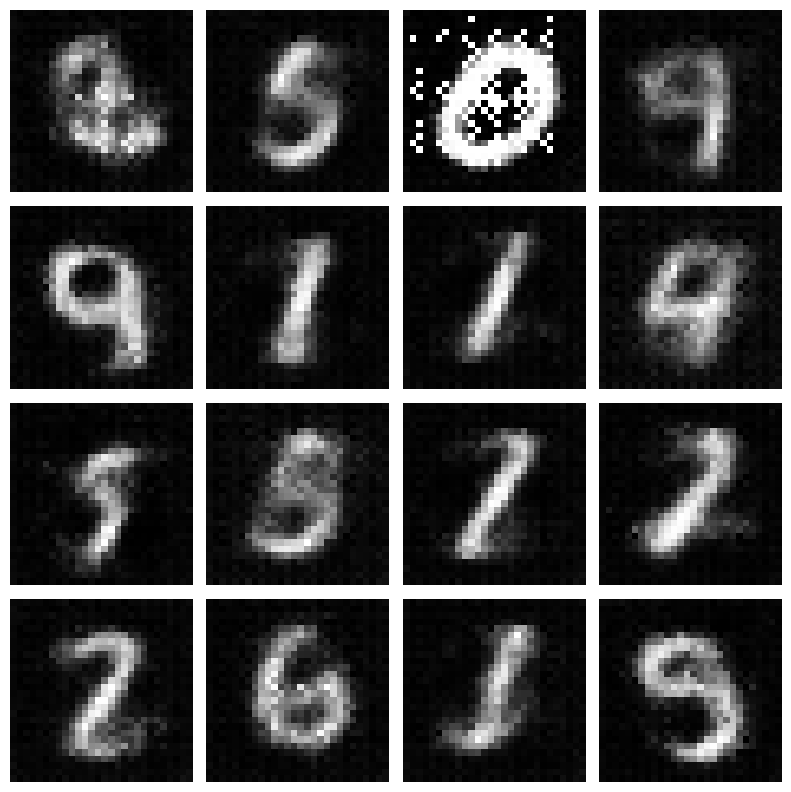

In [12]:
reconstructions = trained_model.reconstruct(eval_dataset[:25].to(device)).detach().cpu()

plot_grid(reconstructions)

In [13]:
eval_dataset[:25].shape

torch.Size([25, 1, 28, 28])

# INTERPOLATIONS

In [ ]:
interpolations = trained_model.interpolate(eval_dataset[:5].to(device), eval_dataset[5:10].to(device), granularity=10) .detach().cpu()

fig, axes = plt.subplots(nrows=5, ncols=10, figsize=(10, 5))

for i in range(5):
    for j in range(10):
        axes[i][j].imshow(interpolations[i, j].cpu().squeeze(0), cmap='gray')
        axes[i][j].axis('off')
plt.tight_layout(pad=0.)

# GENERATE

### Normal Sampler

In [ ]:
from pythae.samplers import NormalSampler


sampler = NormalSampler(
    model=trained_model,
    sampler_config=None
)
gen_data = sampler.sample(
    num_samples=25,
)

In [ ]:
plot_grid(gen_data.data.cpu())

### Gaussian Mixture Model Sampler

In [ ]:
from pythae.samplers import GaussianMixtureSampler, GaussianMixtureSamplerConfig


gmm_sampler_config = GaussianMixtureSamplerConfig(
    n_components=10
)

gmm_sampler = GaussianMixtureSampler(
    sampler_config=gmm_sampler_config,
    model=trained_model
)

gmm_sampler.fit(
    train_data=train_dataset
)

gmm_gen_data = gmm_sampler.sample(
   num_samples=25
)

In [ ]:
plot_grid(gmm_gen_data.data.cpu())

### RHVAE Sampler

In [ ]:
from pythae.samplers import RHVAESampler, RHVAESamplerConfig


rh_sampler_config = RHVAESamplerConfig(
    # mcmc_steps_nbr = 200,
    # n_lf = 3,
    # eps_lf = 1e-3,
    # beta_zero = 0.3
)

rh_sampler = RHVAESampler(
    sampler_config=rh_sampler_config,
    model=trained_model
)

rh_sampler.fit(
    train_data=train_dataset
)

rh_gen_data = rh_sampler.sample(
   num_samples=25
)

In [ ]:
plot_grid(rh_gen_data)

In [ ]:
rh_gen_data.shape

In [ ]:
# #combined_dataset = ConcatDataset([train_dataset, rh_gen_data])
# combined_dataset = torch.cat((train_dataset, rh_gen_data), 0)
# combined_dataset = combined_dataset[torch.randperm(combined_dataset.size()[0])]
# combined_dataset.shape